# d-分离、前门准则与后门准则的代码实现

---

*CCF因果科学暑期夏令营*

中国科学院计算技术研究所 李奉治

08/16/2021

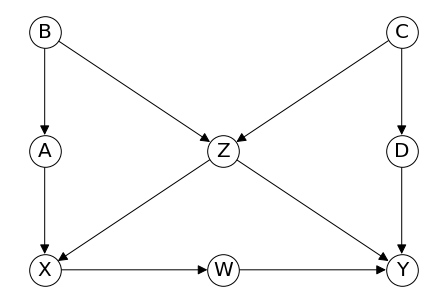

In [1]:
import networkx as nx
# 绘图选项
draw_options = {
    "arrowsize": 20,
    "font_size": 20,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
    "with_labels": True,
}
# 构建有向图并添加结点和边
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'W', 'X', 'Y', 'Z'])
G.add_edges_from([('X', 'W'), ('W', 'Y'), ('Z', 'X'), ('Z', 'Y')])
G.add_edges_from([('B', 'A'), ('A', 'X'), ('B', 'Z')])
G.add_edges_from([('C', 'D'), ('D', 'Y'), ('C', 'Z')])
# 手动编辑绘图时各节点位置
pos={'A': (-0.8, 0.0), 'B': (-0.8, 0.8), 'C': ( 0.8, 0.8), 'D': ( 0.8, 0.0), 
     'W': ( 0.0,-0.8), 'X': (-0.8,-0.8), 'Y': ( 0.8,-0.8), 'Z': ( 0.0, 0.0)}
# 绘出当前有向图
nx.draw(G, **draw_options, pos=pos)

## d-分离

---

一条路径会一组结点 Z 阻断，当且仅当：

1. 路径 $p$ 包含链结构 A→B→C 或分叉结构 A←B→C，且中间结点 B 在 Z 中；或者
2. 路径 $p$ 包含一个对撞结构 A→B←C，且对撞结点 B 及其子孙结点都不在 Z 中

如果 Z 阻断了 X 和 Y 间的每一条路径，则 X 和 Y 在 Z 的条件下是**d-分离**的。

In [2]:
def path_blocked(G, path, z):
    # 对于路径中间的结点逐一判断
    # ['X', 'Z', 'C', 'D', 'Y']
    for i in range(1, len(path)-1):
        # z -> c <- d
        if G.has_edge(path[i-1], path[i]) and G.has_edge(path[i+1], path[i]):
            # 结点path[i]处于对撞结构中
            if path[i] in z:
                # 对撞结点在Z中，此路径无法被此结点阻断，判断下一个结点
                continue

            all_descendants_not_in_z = True
            for des in nx.descendants(G, path[i]):
                # 判断此结点的子孙结点
                if des in z:
                    all_descendants_not_in_z = False
                    break
            if not all_descendants_not_in_z:
                # 某个子孙结点在Z中，此路径无法被此结点阻断，判断下一个结点
                continue

            # 此结点及其子孙结点都不在Z中，此路径可以被此结点阻断，返回True
            print('，且对撞结点', path[i], '被阻断')
            return True
        
        else:
            # 结点path[i]处于链结构或分叉结构中
            if path[i] in z:
                # 此结点在Z中，此路径可以被此结点阻断，返回True
                print('，且结点', path[i], '被阻断')
                return True
            # 否则此结点无法阻断此路径，继续判断下一个结点

    print('，但未被阻断【×】')
    # 已经判断了此路径中的每一个结点，都无法阻断此路径，返回False
    return False

In [3]:
def d_separation(G, x, y, z):
    all_path_blocked = True
    # 获取图G的一个临时无向图副本，用于搜索简单路径
    U_G = G.to_undirected()
    # 通过U_G获取X和Y之间所有的简单路径
    paths = nx.all_simple_paths(U_G, x, y)
    # 逐一判断每个路径是否被阻断
    for path in paths:
        print('  路径', path, end='')
        blocked = path_blocked(G, path, z)
        if not blocked:
            # 此路径未被阻断，不满足d-分离条件
            all_path_blocked = False

    # 结果输出
    if not all_path_blocked:
        print('有路径未被阻断，不满足d-分离准则')
        return False
    else:
        print('所有路径都已被阻断，满足d-分离准则')
        return True

In [4]:
d_separation(G, 'X', 'Y', {'A', 'Z', 'W'})

  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']，且结点 A 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y']，且结点 A 被阻断
  路径 ['X', 'W', 'Y']，且结点 W 被阻断
  路径 ['X', 'Z', 'C', 'D', 'Y']，且结点 Z 被阻断
  路径 ['X', 'Z', 'Y']，且结点 Z 被阻断
所有路径都已被阻断，满足d-分离准则


True

In [5]:
nx.d_separated(G, {'X'}, {'Y'}, {'A', 'Z', 'W'})

True

## 后门准则

---

给定有向无环图中的一对有序变量 (X, Y)，如果变量集合 Z 满足

1. Z 中没有 X 的后代结点，且
2. Z 阻断了 X 与 Y 之间的每条含有指向 X 的路径

则称 Z 满足关于 (X, Y) 的**后门准则**。


In [6]:
def backdoor(G, x, y, z):
    print('正在判断图G中结点集', z, '是否满足关于(', x, ',', y, ')的后门准则')
    
    # 判断是否为有向无环图
    if not nx.is_directed_acyclic_graph(G):
        print('此图不是有向无环图，无法进行后续判断')
        return False
    
    # @@@ 判据1：Z中没有X的后代结点
    # ------------------------------------------------
    # 获取X的所有后代结点
    des_x = nx.descendants(G, x)
    # 判断Z中是否有X的后代结点
    for node in z:
        if node in des_x:
            print('结点', z, '为', x, '的后代结点，不满足第一条判据，不满足后门准则')
            return False

    # @@@ 判据2：Z阻断了X与Y之间的每条含有指向X的路径
    # ------------------------------------------------
    all_path_blocked = True
    # 获取图G的一个临时无向图副本，用于搜索简单路径
    U_G = G.to_undirected()
    # 通过U_G获取X和Y之间所有的简单路径
    paths = nx.all_simple_paths(U_G, x, y)
    # 逐一判断每个路径是否为指向X的路径，如果是指向X的路径检测其是否被阻断
    for path in paths:
        print('  路径', path, end='')
        if G.has_edge(path[1], path[0]):
            print('是指向X的路径', end='')
            blocked = path_blocked(G, path, z)
            if not blocked:
                # 此路径未被阻断，使得后门准则不满足
                all_path_blocked = False
        else:
            print('不是指向X的路径')
    
    # 结果输出
    if not all_path_blocked:
        print('有后门路径未被阻断，不满足后门准则\n')
        return False
    else:
        print('所有后门路径都已被阻断，满足后门准则\n')
        return True

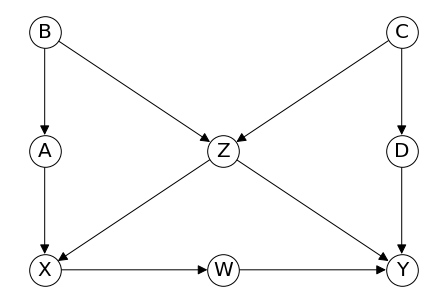

In [7]:
nx.draw(G, **draw_options, pos=pos)

In [8]:
backdoor(G, 'X', 'Y', {'A','Z'})

正在判断图G中结点集 {'A', 'Z'} 是否满足关于( X , Y )的后门准则
  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']是后门路径，且结点 A 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y']是后门路径，且结点 A 被阻断
  路径 ['X', 'W', 'Y']不是后门路径
  路径 ['X', 'Z', 'C', 'D', 'Y']是后门路径，且结点 Z 被阻断
  路径 ['X', 'Z', 'Y']是后门路径，且结点 Z 被阻断
所有后门路径都已被阻断，满足后门准则



True

In [9]:
backdoor(G, 'X', 'W', {'Z'})

正在判断图G中结点集 {'Z'} 是否满足关于( X , W )的后门准则
  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y', 'W']是后门路径，且对撞结点 Y 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y', 'W']是后门路径，且结点 Z 被阻断
  路径 ['X', 'W']不是后门路径
  路径 ['X', 'Z', 'C', 'D', 'Y', 'W']是后门路径，且结点 Z 被阻断
  路径 ['X', 'Z', 'Y', 'W']是后门路径，且结点 Z 被阻断
所有后门路径都已被阻断，满足后门准则



True

### 思考题3.3.1(a)

列出所有满足后门准则的变量集合，以确定X对Y的因果效应

---

In [10]:
# 求出所有可能的变量集合
from itertools import chain, combinations
v = ['A', 'B', 'C', 'D', 'W', 'Z']
powersets = list(chain.from_iterable(combinations(v, r) for r in range(len(v)+1)))
for sets in powersets: 
    print(sets, end='')


()('A',)('B',)('C',)('D',)('W',)('Z',)('A', 'B')('A', 'C')('A', 'D')('A', 'W')('A', 'Z')('B', 'C')('B', 'D')('B', 'W')('B', 'Z')('C', 'D')('C', 'W')('C', 'Z')('D', 'W')('D', 'Z')('W', 'Z')('A', 'B', 'C')('A', 'B', 'D')('A', 'B', 'W')('A', 'B', 'Z')('A', 'C', 'D')('A', 'C', 'W')('A', 'C', 'Z')('A', 'D', 'W')('A', 'D', 'Z')('A', 'W', 'Z')('B', 'C', 'D')('B', 'C', 'W')('B', 'C', 'Z')('B', 'D', 'W')('B', 'D', 'Z')('B', 'W', 'Z')('C', 'D', 'W')('C', 'D', 'Z')('C', 'W', 'Z')('D', 'W', 'Z')('A', 'B', 'C', 'D')('A', 'B', 'C', 'W')('A', 'B', 'C', 'Z')('A', 'B', 'D', 'W')('A', 'B', 'D', 'Z')('A', 'B', 'W', 'Z')('A', 'C', 'D', 'W')('A', 'C', 'D', 'Z')('A', 'C', 'W', 'Z')('A', 'D', 'W', 'Z')('B', 'C', 'D', 'W')('B', 'C', 'D', 'Z')('B', 'C', 'W', 'Z')('B', 'D', 'W', 'Z')('C', 'D', 'W', 'Z')('A', 'B', 'C', 'D', 'W')('A', 'B', 'C', 'D', 'Z')('A', 'B', 'C', 'W', 'Z')('A', 'B', 'D', 'W', 'Z')('A', 'C', 'D', 'W', 'Z')('B', 'C', 'D', 'W', 'Z')('A', 'B', 'C', 'D', 'W', 'Z')

In [11]:
# 逐一验证每个变量集合是否满足后门准则
backdoor_sets = []
for sets in powersets:
    if backdoor(G, 'X', 'Y', sets):
        backdoor_sets.append(sets)

正在判断图G中结点集 () 是否满足关于( X , Y )的后门准则
  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']是后门路径，且对撞结点 Z 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y']是后门路径，但未被阻断【×】
  路径 ['X', 'W', 'Y']不是后门路径
  路径 ['X', 'Z', 'C', 'D', 'Y']是后门路径，但未被阻断【×】
  路径 ['X', 'Z', 'Y']是后门路径，但未被阻断【×】
有后门路径未被阻断，不满足后门准则

正在判断图G中结点集 ('A',) 是否满足关于( X , Y )的后门准则
  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']是后门路径，且结点 A 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y']是后门路径，且结点 A 被阻断
  路径 ['X', 'W', 'Y']不是后门路径
  路径 ['X', 'Z', 'C', 'D', 'Y']是后门路径，但未被阻断【×】
  路径 ['X', 'Z', 'Y']是后门路径，但未被阻断【×】
有后门路径未被阻断，不满足后门准则

正在判断图G中结点集 ('B',) 是否满足关于( X , Y )的后门准则
  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']是后门路径，且结点 B 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y']是后门路径，且结点 B 被阻断
  路径 ['X', 'W', 'Y']不是后门路径
  路径 ['X', 'Z', 'C', 'D', 'Y']是后门路径，但未被阻断【×】
  路径 ['X', 'Z', 'Y']是后门路径，但未被阻断【×】
有后门路径未被阻断，不满足后门准则

正在判断图G中结点集 ('C',) 是否满足关于( X , Y )的后门准则
  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']是后门路径，且对撞结点 Z 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y']是后门路径，但未被阻断【×】
  路径 ['X', 'W', 'Y']不是后门路径
  路径 ['X', 'Z', 'C', 'D', 'Y']是后门

In [12]:
print(backdoor_sets)

[('A', 'Z'), ('B', 'Z'), ('C', 'Z'), ('D', 'Z'), ('A', 'B', 'Z'), ('A', 'C', 'Z'), ('A', 'D', 'Z'), ('B', 'C', 'Z'), ('B', 'D', 'Z'), ('C', 'D', 'Z'), ('A', 'B', 'C', 'Z'), ('A', 'B', 'D', 'Z'), ('A', 'C', 'D', 'Z'), ('B', 'C', 'D', 'Z'), ('A', 'B', 'C', 'D', 'Z')]


## 前门准则

---

给定有向无环图中的一对有序变量 (X, Y)，如果变量集合 Z 满足

1. Z 切断了所有 X 到 Y 的有向路径，
2. X 到 Z 没有后门路径
3. 所有 Z 到 Y 的后门路径都被 X 阻断

则称 Z 满足关于 (X, Y) 的**前门准则**。

In [13]:
def frontdoor(G, x, y, z):    
    print('正在判断图G中结点集', z, '是否满足关于(', x, ',', y, ')的前门准则')
    
    # 判断是否为有向无环图
    if not nx.is_directed_acyclic_graph(G):
        print('此图不是有向无环图，无法进行后续判断')
        return False
    
    # @@@ 判据1：Z切断了所有X到Y的有向路径
    # ------------------------------------------------
    # 获取所有X到Y的有向路径
    directed_paths = nx.all_simple_paths(G, x, y)
    for path in directed_paths:
        print('  路径', path, '是结点', x, '到结点', y, '的有向路径', end='')
        if not path_blocked(G, path, z):
            print('不满足第一条判据，因此不满足前门准则\n')
            return False

    # @@@ 判据2：X到Z没有后门路径（即空集满足(X,Z)的后门准则）
    # ------------------------------------------------
    for node in z:
        backdoor_path_not_exist = backdoor(G, x, node, {})
        if not backdoor_path_not_exist:
            print('不满足第二条判据，因此不满足前门准则\n')
            return False

    # @@@ 判据3：所有Z到Y的后门路径都被X阻断（即X满足(Z,Y)的后门准则）
    # ------------------------------------------------
    for node in z:
        backdoor_path_blocked = backdoor(G, node, y, {x})
        if not backdoor_path_blocked:
            print('不满足第三条判据，因此不满足前门准则\n')
            return False
    
    # 所有判据皆通过
    print('所有判据通过，满足前门准则\n')
    return True

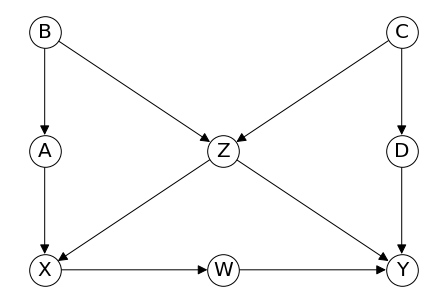

In [14]:
nx.draw(G, **draw_options, pos=pos)

In [15]:
frontdoor(G, 'X', 'Y', {'W'})

正在判断图G中结点集 {'W'} 是否满足关于( X , Y )的前门准则
  路径 ['X', 'W', 'Y'] 是结点 X 到结点 Y 的有向路径，且结点 W 被阻断
正在判断图G中结点集 {} 是否满足关于( X , W )的后门准则
  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y', 'W']是后门路径，且对撞结点 Z 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y', 'W']是后门路径，且对撞结点 Y 被阻断
  路径 ['X', 'W']不是后门路径
  路径 ['X', 'Z', 'C', 'D', 'Y', 'W']是后门路径，且对撞结点 Y 被阻断
  路径 ['X', 'Z', 'Y', 'W']是后门路径，且对撞结点 Y 被阻断
所有后门路径都已被阻断，满足后门准则

正在判断图G中结点集 {'X'} 是否满足关于( W , Y )的后门准则
  路径 ['W', 'Y']不是后门路径
  路径 ['W', 'X', 'A', 'B', 'Z', 'C', 'D', 'Y']是后门路径，且结点 X 被阻断
  路径 ['W', 'X', 'A', 'B', 'Z', 'Y']是后门路径，且结点 X 被阻断
  路径 ['W', 'X', 'Z', 'C', 'D', 'Y']是后门路径，且结点 X 被阻断
  路径 ['W', 'X', 'Z', 'Y']是后门路径，且结点 X 被阻断
所有后门路径都已被阻断，满足后门准则

所有判据通过，满足前门准则



True

In [16]:
frontdoor(G, 'X', 'Y', {'Z', 'W'})

正在判断图G中结点集 {'Z', 'W'} 是否满足关于( X , Y )的前门准则
  路径 ['X', 'W', 'Y'] 是结点 X 到结点 Y 的有向路径，且结点 W 被阻断
正在判断图G中结点集 {} 是否满足关于( X , Z )的后门准则
  路径 ['X', 'A', 'B', 'Z']是后门路径，但未被阻断【×】
  路径 ['X', 'W', 'Y', 'D', 'C', 'Z']不是后门路径
  路径 ['X', 'W', 'Y', 'Z']不是后门路径
  路径 ['X', 'Z']是后门路径，但未被阻断【×】
有后门路径未被阻断，不满足后门准则

不满足第二条判据，因此不满足前门准则



False

### 思考题3.4.1

假设在图中只能测量 X，Y 和一个附加变量，哪个变量可用于确定 X 对 Y的因果效应？请找出并计算 X 对 Y 的因果效应。

---

In [17]:
v = ['A', 'B', 'C', 'D', 'W', 'Z']
backdoor_nodes = []
for node in v:
    if backdoor(G, 'X', 'Y', {node}):
        backdoor_nodes.append(node)

frontdoor_nodes = []
for node in v:
    if frontdoor(G, 'X', 'Y', {node}):
        frontdoor_nodes.append(node)

正在判断图G中结点集 {'A'} 是否满足关于( X , Y )的后门准则
  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']是后门路径，且结点 A 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y']是后门路径，且结点 A 被阻断
  路径 ['X', 'W', 'Y']不是后门路径
  路径 ['X', 'Z', 'C', 'D', 'Y']是后门路径，但未被阻断【×】
  路径 ['X', 'Z', 'Y']是后门路径，但未被阻断【×】
有后门路径未被阻断，不满足后门准则

正在判断图G中结点集 {'B'} 是否满足关于( X , Y )的后门准则
  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']是后门路径，且结点 B 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y']是后门路径，且结点 B 被阻断
  路径 ['X', 'W', 'Y']不是后门路径
  路径 ['X', 'Z', 'C', 'D', 'Y']是后门路径，但未被阻断【×】
  路径 ['X', 'Z', 'Y']是后门路径，但未被阻断【×】
有后门路径未被阻断，不满足后门准则

正在判断图G中结点集 {'C'} 是否满足关于( X , Y )的后门准则
  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']是后门路径，且对撞结点 Z 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y']是后门路径，但未被阻断【×】
  路径 ['X', 'W', 'Y']不是后门路径
  路径 ['X', 'Z', 'C', 'D', 'Y']是后门路径，且结点 C 被阻断
  路径 ['X', 'Z', 'Y']是后门路径，但未被阻断【×】
有后门路径未被阻断，不满足后门准则

正在判断图G中结点集 {'D'} 是否满足关于( X , Y )的后门准则
  路径 ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']是后门路径，且对撞结点 Z 被阻断
  路径 ['X', 'A', 'B', 'Z', 'Y']是后门路径，但未被阻断【×】
  路径 ['X', 'W', 'Y']不是后门路径
  路径 ['X', 'Z', 'C', 'D', 'Y']是后

In [18]:
print('满足后门准则的结点：')
print(backdoor_nodes)
print('满足前门准则的结点：')
print(frontdoor_nodes)

满足后门准则的结点：
[]
满足前门准则的结点：
['W']


根据前门校正公式，X 对 Y 的因果效应可以表示为
$$ P(y\ |\ do(x)) = \sum_wP(w\ |\ x)\sum_{x'}P(y\ |\ x', w)P(x') $$

## Ananke 的使用

参考链接：https://ananke.readthedocs.io/en/latest/index.html

In [ ]:
! pip3 install ananke-causal

In [ ]:
from ananke.graphs import ADMG
from ananke.identification import OneLineID
from ananke.estimation import CausalEffect
from ananke.datasets import load_afixable_data
from ananke.estimation import AutomatedIF
import numpy as np

In [ ]:
vertices = ['Income', 'Insurance', 'ViralLoad', 'Education', 'T', 'Toxicity', 'CD4']
di_edges = [('ViralLoad', 'Income'), ('ViralLoad', 'T'), ('ViralLoad', 'Toxicity'),
            ('Education', 'Income'), ('Education', 'T'), ('Education', 'Toxicity'),
            ('Income', 'Insurance'), ('Insurance', 'T'), ('T', 'Toxicity'), ('Toxicity', 'CD4'), ('T', 'CD4')]
bi_edges = [('Income', 'T'), ('Insurance', 'ViralLoad'), ('Education', 'CD4')]
G = ADMG(vertices, di_edges, bi_edges)
G.draw(direction="LR")

In [ ]:
one_id = OneLineID(graph=G, treatments=['T'], outcomes=['CD4'])
one_id.id()
one_id.functional()

In [ ]:
vertices = ['A', 'B', 'C', 'D', 'W', 'X', 'Y', 'Z']
di_edges = [('X', 'W'), ('W', 'Y'), ('Z', 'X'), ('Z', 'Y'),
       ('B', 'A'), ('A', 'X'), ('B', 'Z'),
       ('C', 'D'), ('D', 'Y'), ('C', 'Z')]
G = ADMG(vertices, di_edges)
G.draw(direction="LR")

In [ ]:
one_id = OneLineID(graph=G, treatments=['X'], outcomes=['Y'])
one_id.functional()